У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import pandas as pd
import numpy as np

train_path = '../../../data/time_series/train.csv'
# train_path = '/content/drive/MyDrive/data/time series/train.csv'


df = pd.read_csv(train_path)
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [7]:
df['item'].nunique(), df['store'].nunique()

(50, 10)

In [8]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


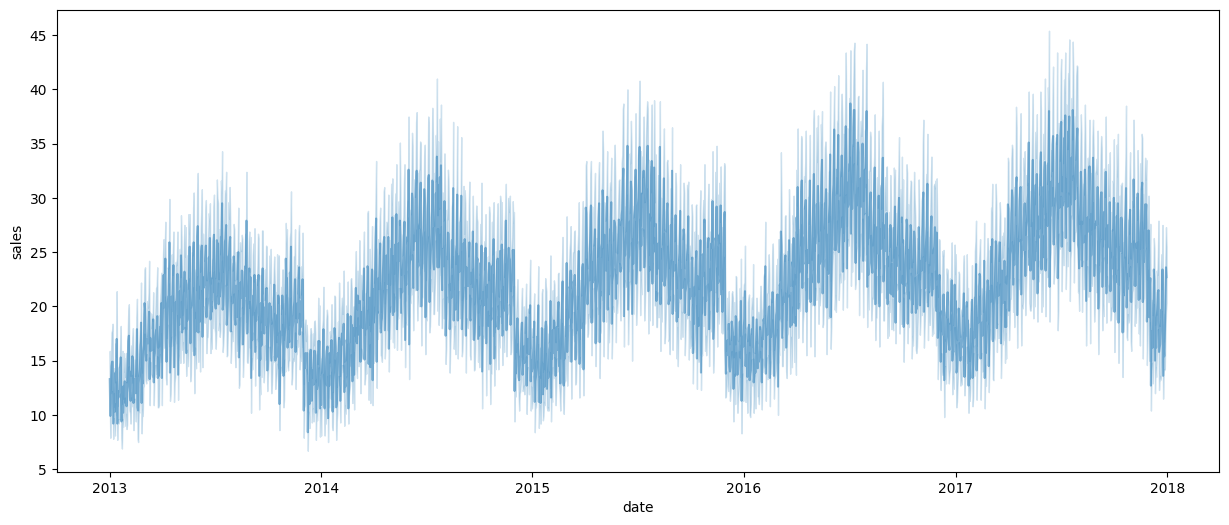

In [9]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df[df.item == 1], x='date', y='sales', alpha=0.5);

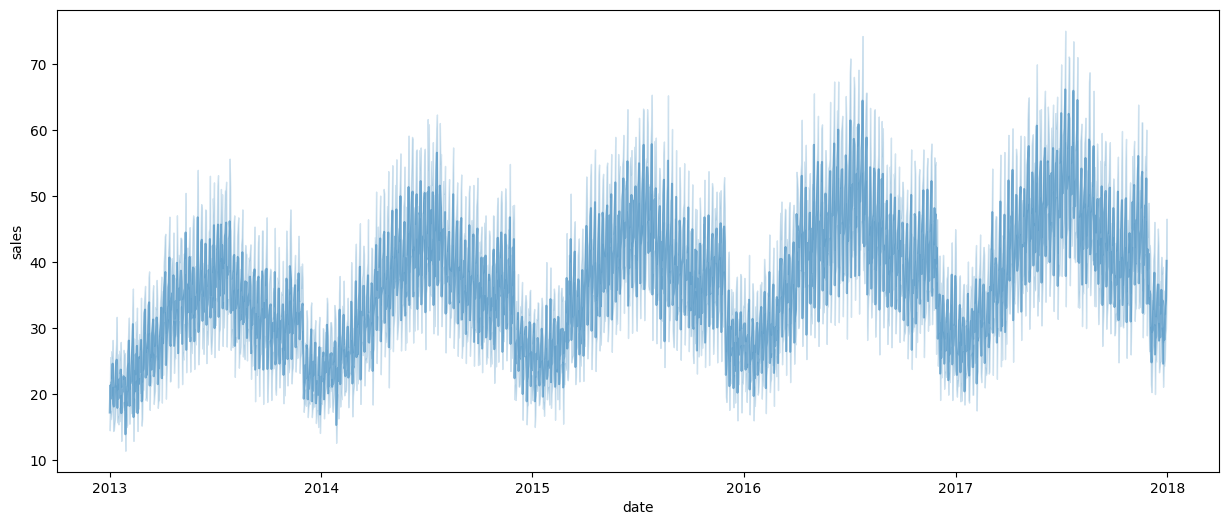

In [10]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df[df.item == 3], x='date', y='sales', alpha=0.5);

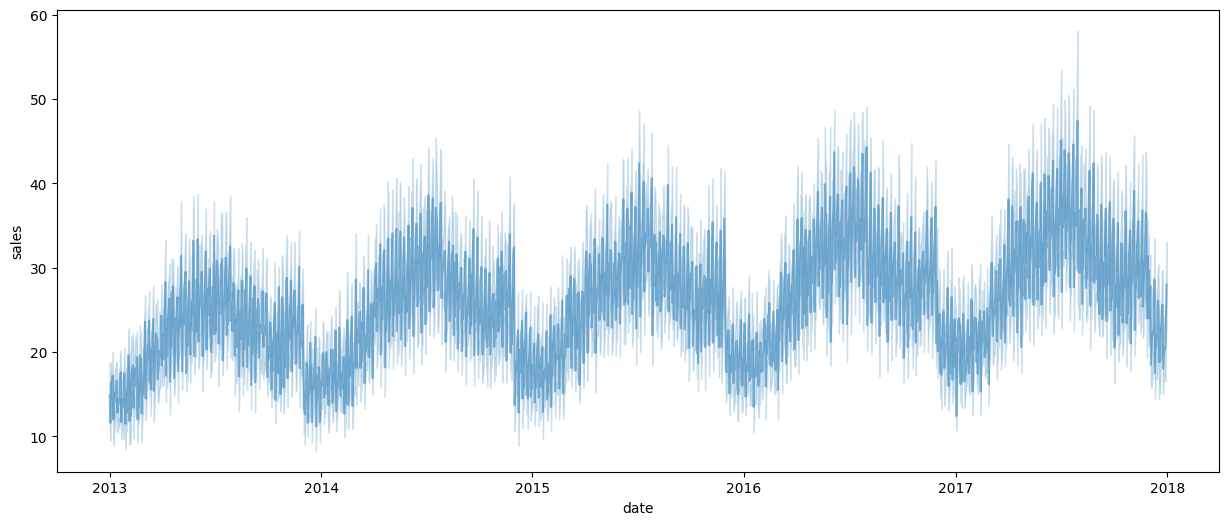

In [11]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df[df.item == 34], x='date', y='sales', alpha=0.5);

Для різних товарів динаміка продажів схожа, проте відрізняються об'єми

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [8]:
df_item1_store1 = pd.DataFrame(df[(df.item == 1) & (df.store == 1) ]['sales'])
# df_item1_store1 = df[(df.item == 1) & (df.store == 1) ]

df_item1_store1.head()

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


In [9]:
latest_date = df_item1_store1.index.max()
last_two_months = df_item1_store1.loc[df_item1_store1.index >= latest_date - pd.Timedelta(days=60)]

In [10]:
freq = pd.infer_freq(last_two_months.index)
print(freq)

D


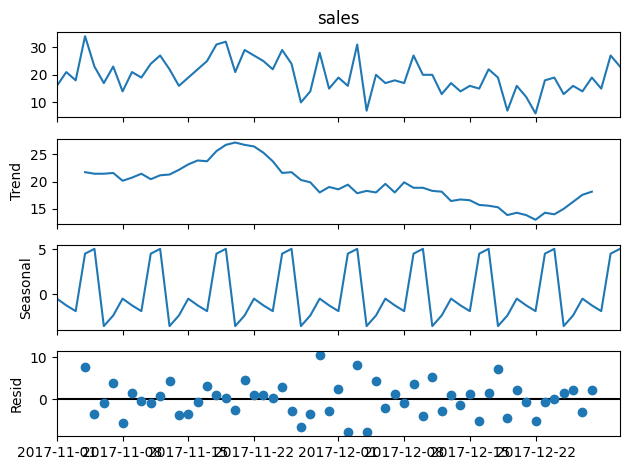

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_plot_multi = seasonal_decompose(last_two_months['sales'],
                                              model='additive')

decomposition_plot_multi.plot()
plt.show()

З візуалізації видно що дані мають немало резидуалів, і вони мають доволі помітне відхилення відносно діапазону даних. Також можна побачити деяку залежність в росподілі залишків.  

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [12]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 51.4 MB/s eta 0:

In [13]:
from darts import TimeSeries

series  = TimeSeries.from_dataframe(df_item1_store1, value_cols='sales')
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

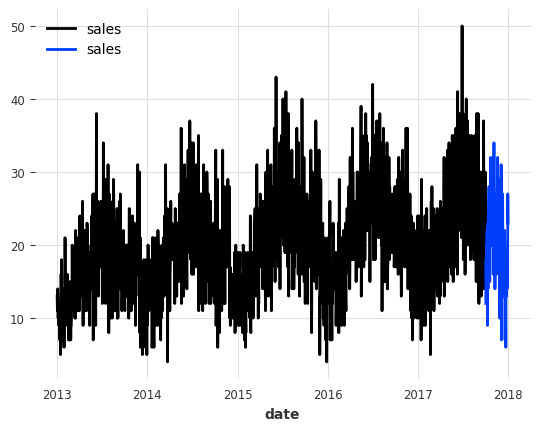

In [14]:
series_train, series_val = series.split_after(pd.Timestamp('2017-10-01'))
series_train.plot()
series_val.plot()


6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1000x600 with 0 Axes>

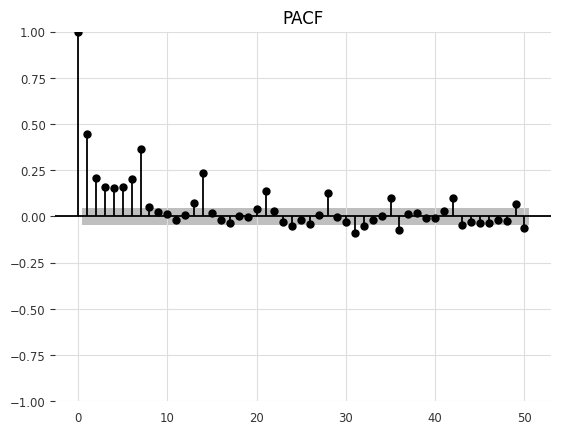

In [16]:
plt.figure(figsize=(10, 6))
plot_pacf(df_item1_store1, lags=50, method='ywm')
plt.title('PACF')
plt.show()

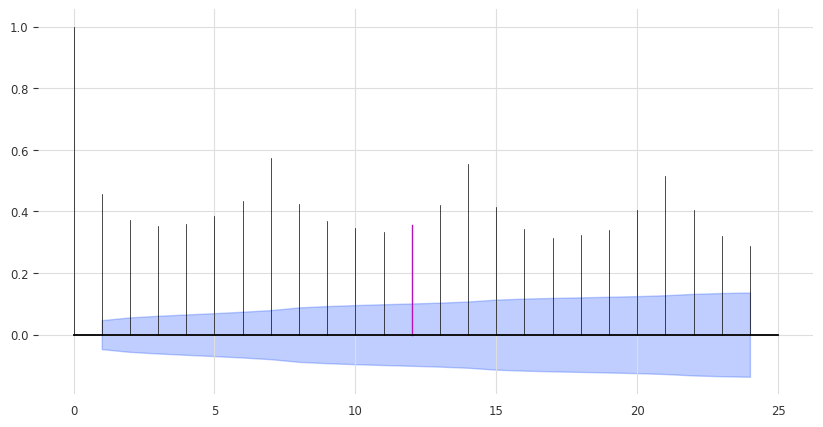

In [17]:
from darts.utils.statistics import plot_acf

plot_acf(series_train, m = 12,  alpha=0.05, max_lag=24)

З побудованого графіку часткової автокореляційної функції видно, що найбільший вплив має кожен 7 лаг

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [18]:
from darts.utils.statistics import check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(series_train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [19]:
# from darts.models import NaiveDrift, NaiveSeasonal


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




<Axes: xlabel='date'>

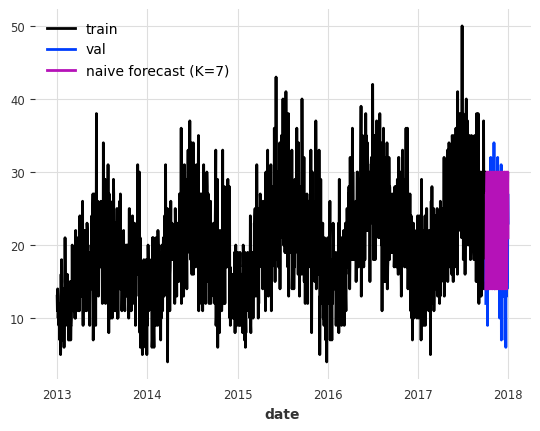

In [20]:
from darts.models import NaiveDrift, NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=7)
naive_seasonal.fit(series_train)
naive_seasonal_pred = naive_seasonal.predict(len(series_val))

series_train.plot(label="train")
series_val.plot(label="val")
naive_seasonal_pred.plot(label="naive forecast (K=7)")



In [21]:
len(series_val)

91

На отриманому графіку одразу відображено забагато точок даних, виведемо лише частину передбачень для кращого розуміння

<Axes: xlabel='date'>

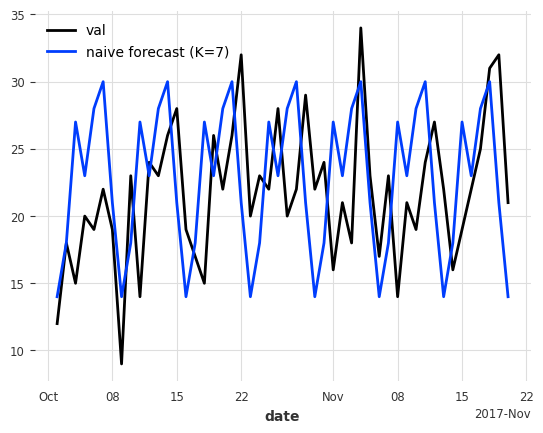

In [22]:
series_val[:50].plot(label="val")
naive_seasonal_pred[:50].plot(label="naive forecast (K=7)")


<Axes: xlabel='date'>

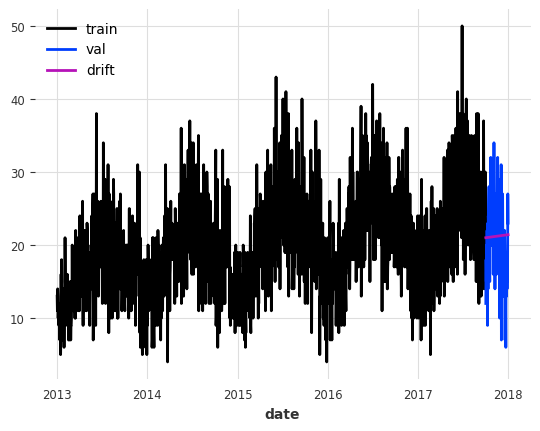

In [23]:
naive_drift = NaiveDrift()
naive_drift.fit(series_train)
naive_drift_pred = naive_drift.predict(len(series_val))

series_train.plot(label='train')
series_val.plot(label="val")
naive_drift_pred.plot(label="drift")

<Axes: xlabel='date'>

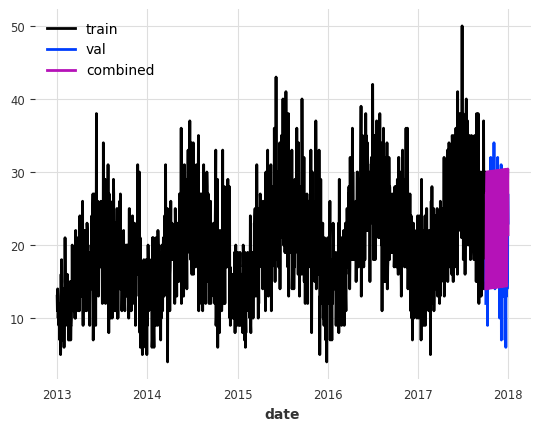

In [24]:
combined_forecast = naive_drift_pred + naive_seasonal_pred - series_train.last_value()

series_train.plot(label="train")
series_val.plot(label="val")

combined_forecast.plot(label="combined")


<Axes: xlabel='date'>

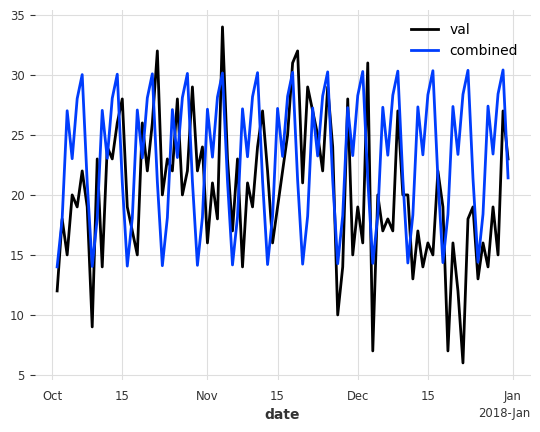

In [25]:
series_val.plot(label="val")
combined_forecast.plot(label="combined")


Отримана модель хоч і вхоплює тенденцію у даних, не є достатньо точною, що видно з візуалізації

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [26]:
from darts.metrics import mape

def get_mape(forecast, model_name):
  print(
      f"MAPE for {model_name}: {mape(series, forecast):.2f}%."
  )

get_mape(combined_forecast, 'Combined naive drift + Seasonal')

MAPE for Combined naive drift + Seasonal: 39.47%.


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [27]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

In [28]:
series_train.pd_dataframe()

component,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0
...,...
2017-09-27,27.0
2017-09-28,23.0
2017-09-29,28.0


In [29]:

def enrich_with_date_features(df):

  df["hour"] = df['date'].dt.hour
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day

  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(series_train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(series_val.pd_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(series_train)
test_transformed = scaler.transform(series_val)

xgb_model = XGBModel(

    # lags=14,
    lags=7,
    output_chunk_length=1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)



In [30]:
xgb_model.fit(train_transformed)
pred = xgb_model.predict(6)
pred.values()

array([[0.35704038],
       [0.3894598 ],
       [0.4541336 ],
       [0.42094207],
       [0.47126928],
       [0.48382398]], dtype=float32)

In [31]:
def plot_pred(forecast, zoom=False):
  if zoom:
    series_train[-50:].plot(label='Train Data')
  else:
    series_train.plot(label='Train Data')

  series_val.plot(label="Val Data")
  forecast.plot(label='Forecast', color='red')

  plt.legend()
  plt.show()

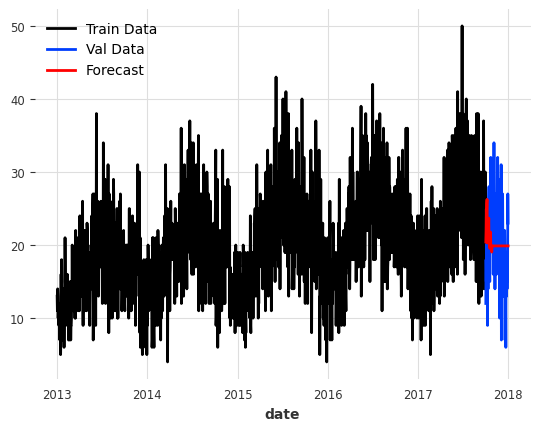

In [32]:
forecast = scaler.inverse_transform(xgb_model.predict(len(series_val)))

plot_pred(forecast, zoom=False)

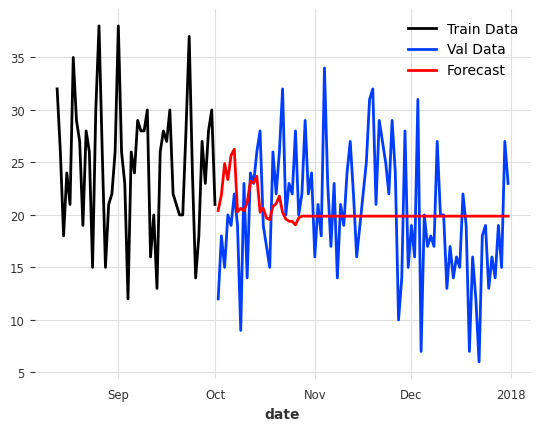

In [33]:
plot_pred(forecast, zoom=True)


In [34]:
get_mape(forecast, 'XGB Model')

MAPE for XGB Model: 29.22%.


Значення MAPE для отриманої можелі трохи краще ніж в наївної, проте на візуалізації передбачень проти справжніх даних видно, що модель всеодно дає недостатньо точні результати

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

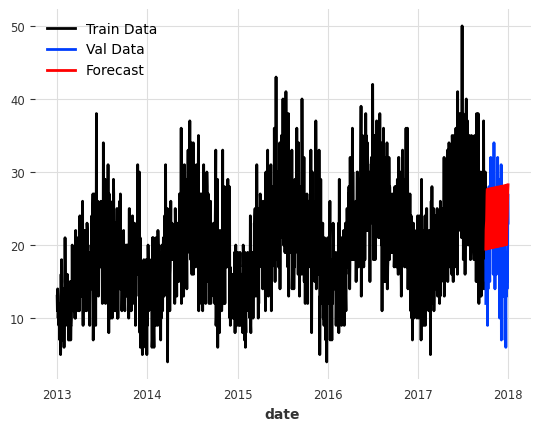

In [35]:
from darts.models import ExponentialSmoothing

es_model = ExponentialSmoothing()
es_model.fit(series_train)
forecast = es_model.predict(len(series_val))

plot_pred(forecast)

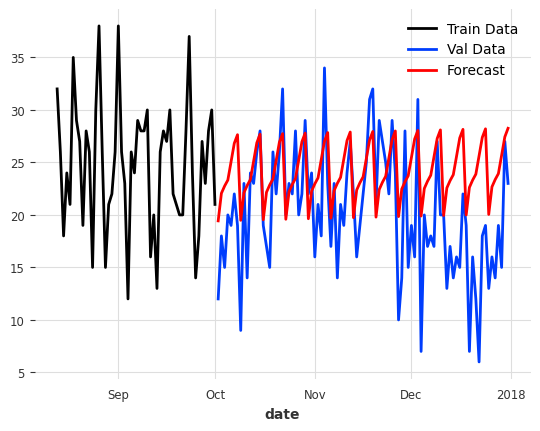

In [36]:
plot_pred(forecast, zoom=True)


In [37]:
get_mape(forecast, "Exponential Smoothing Model")


MAPE for Exponential Smoothing Model: 36.16%.


Візуально результати моделі ввиглядають краще ніж в попередньої, проте значення MAPE в неї вище і вона не є достатньо точною

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



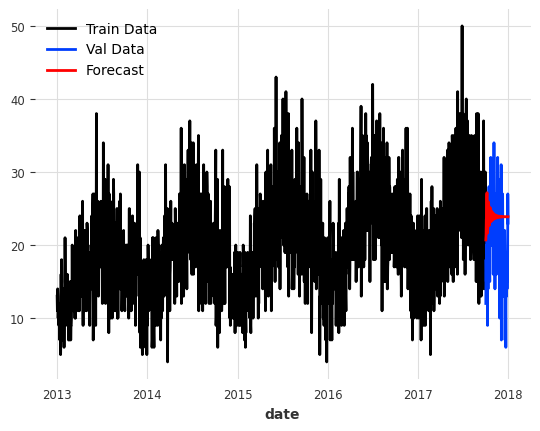

In [38]:
from darts.models import ARIMA

arima = ARIMA(p=12, d=1, q=1)
arima.fit(series_train)
forecast = arima.predict(len(series_val))

plot_pred(forecast)


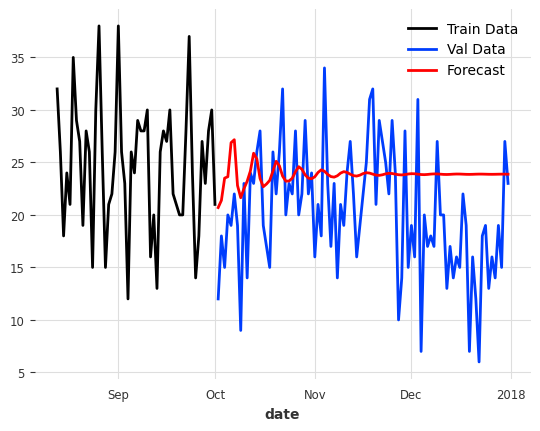

In [39]:
plot_pred(forecast, zoom=True)


In [40]:
get_mape(forecast, 'ARIMA')

MAPE for ARIMA: 37.94%.


In [41]:
?ARIMA

Значення MAPE для моделі гірше ніж в попередніх і на візуалізації видно що модель є недостатньо точною

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

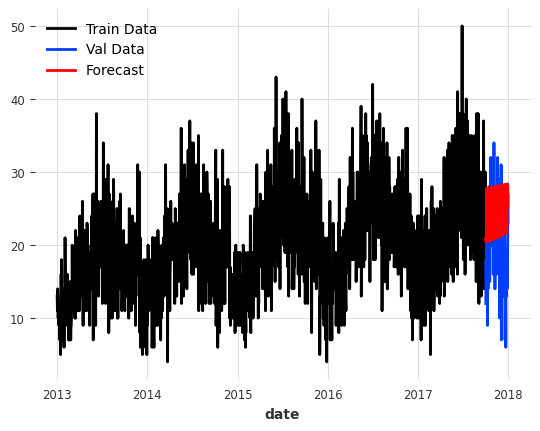

In [42]:
from darts.models import AutoARIMA

auto_arima = AutoARIMA(start_p=3, max_p=7, start_q=3)
auto_arima.fit(series_train)

forecast = auto_arima.predict(len(series_val))

plot_pred(forecast)


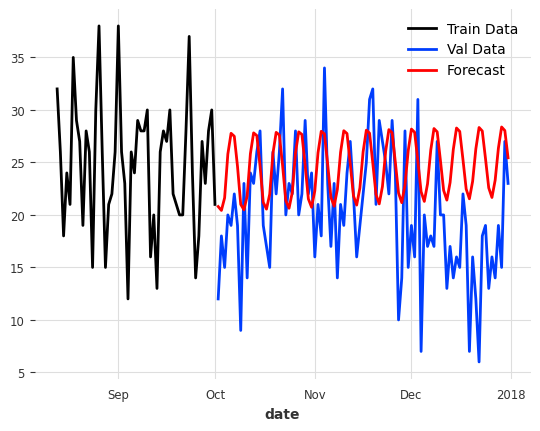

In [43]:
plot_pred(forecast, zoom=True)


In [44]:
auto_arima.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1735
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -5228.788
Date:                Wed, 25 Sep 2024   AIC                          10479.575
Time:                        20:32:54   BIC                          10539.616
Sample:                             0   HQIC                         10501.780
                               - 1735                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0339      0.030      1.135      0.256      -0.025       0.093
ar.L1         -0.5148      0.028    -18.647      0.000      -0.569      -0.461
ar.L2          0.2532      0.014     17.861      0.000       0.225       0.281
ar.L3         -0.5824      0.013    -45.107      0.000      -0.608      -0.557
ar.L4         -0.9369      0.026    -36.011      0.000      -0.988      -0.886
ma.L1         -0.4157      0.039    -10.765      0.000      -0.491      -0.340
ma.L2         -0.7194      0.050    -14.288      0.000      -0.818      -0.621
ma.L3          0.8193      0.031     26.382      0.000       0.758       0.880
ma.L4          0.3537      0.047      7.551      0.000       0.262       0.446
ma.L5         -0.7931      0.035    -22.450      0.000      -0.862      -0.724
sigma2        24.5947      0.767     32.046      0.000      23.091      26.099
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                27.56
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
get_mape(forecast, 'Auto ARIMA')


MAPE for Auto ARIMA: 40.15%.


Якість отрманої автоматичним підбором параметрів моделі не покращилась

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tbq3foc/bsdudott.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tbq3foc/u72e9fcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56025', 'data', 'file=/tmp/tmp6tbq3foc/bsdudott.json', 'init=/tmp/tmp6tbq3foc/u72e9fcu.json', 'output', 'file=/tmp/tmp6tbq3foc/prophet_model_172tdm8/prophet_model-20240925203254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


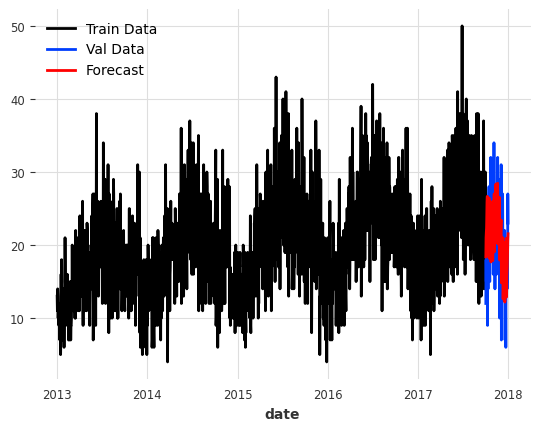

In [46]:
from darts.models import Prophet

prophet = Prophet()
prophet.fit(series_train)

forecast = prophet.predict(len(series_val))

plot_pred(forecast)


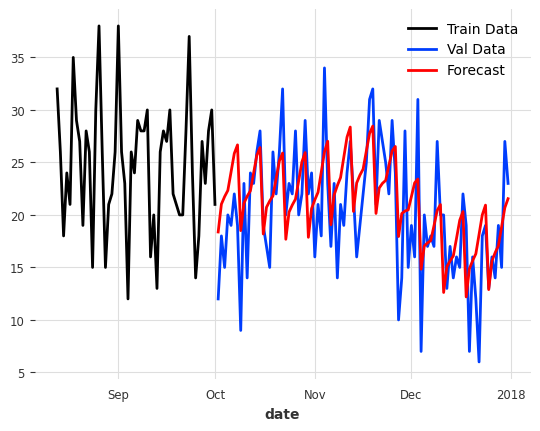

In [47]:
plot_pred(forecast, zoom=True)


In [48]:
get_mape(forecast, 'Prophet')


MAPE for Prophet: 23.67%.


Отримана модель Prophet дає доволі непогані в порівнянні з попередніми моделями результати, маючи значно кращий показник MAPE

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable p

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=700` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

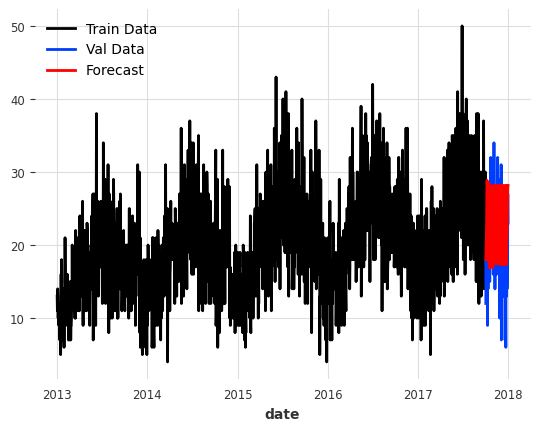

In [49]:
from darts.models import RNNModel

EPOCHS = 700

rnn = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=EPOCHS)
rnn.fit(series_train)

forecast = rnn.predict(len(series_val))

plot_pred(forecast)

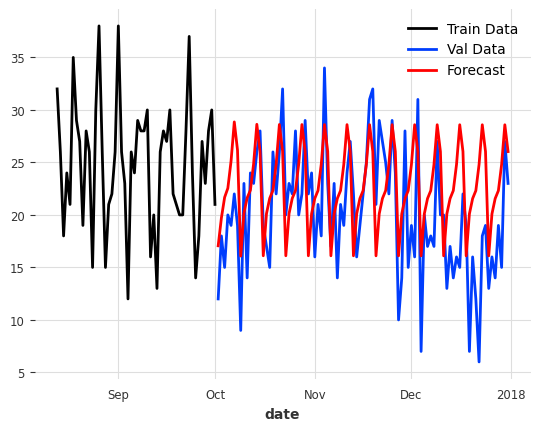

MAPE for RNN 700 epochs: 32.42%.


In [ ]:
plot_pred(forecast, zoom=True)
get_mape(forecast, f'RNN {EPOCHS} epochs')


RNN модель дала кращі результати ніж простіші моделі, проте гірші ніж Prophet

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [ ]:
hfc_params = {
    'series': series,
    'start': pd.Timestamp('2017-01-01'),
    'forecast_horizon': 1,
    'verbose': True
}

hfc = prophet.historical_forecasts(last_points_only=True, **hfc_params)

MAPE for BT: 20.89%.


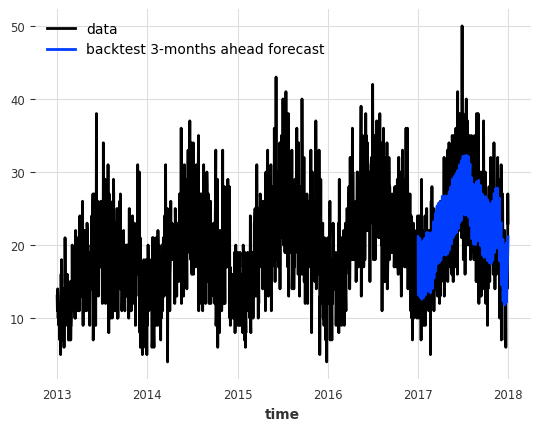

In [52]:
series.plot(label="data")
hfc.plot(label="backtest 3-months ahead forecast")
# print(f"MAPE = {mape(series, historical_fcast):.2f}%")
get_mape(hfc, 'BT')

In [ ]:
raw_errors = prophet.backtest(metric=mape, reduction=None, last_points_only=False, stride=1, **hfc_params)

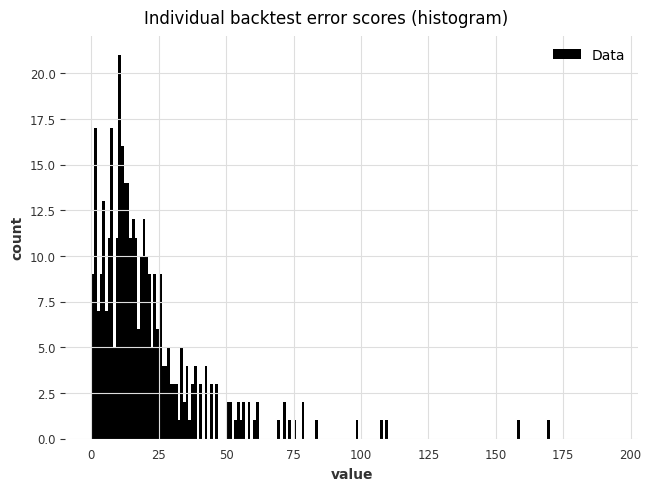

In [58]:
from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

Можель prophet дала непогані результати при бектесті, навіть трохи кращі ніж пр простому прогнозуванні

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Так як модель prophet показала себе найкраще, я б скоріш за все використовувала її. Також можна було б дослідити модель RNN з різними гіперпараметрами.

Найперше що приходить на думку це тренувати окремо моделі для кожного айтема в кожному магазині